# Uptake of carbon, heat, and oxygen

Plotting a global map of carbon, heat, and oxygen uptake

In [12]:
from dask.distributed import Client

client = Client("tcp://10.32.15.112:38245")
client

Client Scheduler: tcp://10.32.15.112:38245 Dashboard: /user/0000-0003-0487-8518/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [13]:
%matplotlib inline

import xarray as xr
import intake
import numpy as np
from cmip6_preprocessing.preprocessing import read_data
import warnings
import matplotlib.pyplot as plt

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [14]:
def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

In [29]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6_update_2019_10_18.json")

In [30]:
cat = col.search(experiment_id=['historical'], table_id='Omon', variable_id=['dissic'], grid_label='gr')

import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [34]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, table_id=['Omon','Ofx'], 
                 variable_id=['dissic'], grid_label=['gn','gr'])  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# for oxygen, ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# UKESM has an issue with the attributes
models = models - {'UKESM1-0-LL','GISS-E2-1-G-CC','GISS-E2-1-G','MCM-UA-1-0'}

models = list(models)
models

['GFDL-ESM4',
 'MIROC-ES2L',
 'GFDL-CM4',
 'CNRM-ESM2-1',
 'IPSL-CM6A-LR',
 'CESM2',
 'CanESM5']

In [10]:
# read all data with thickness and DIC for DIC storage
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict_thk = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['thkcello','dissic'],
                    table_id = ['Omon'],
                    source_id = models,
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['thkcello','dissic']
                    )
#data_dict_thk['IPSL-CM6A-LR'] = data_dict_thk['IPSL-CM6A-LR'].rename({'olevel':'lev'})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [22]:
# read all data with volume and oxygen
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict_dic = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['dissic'],
                    table_id = ['Omon'],
                    source_id = models,
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['dissic']
                    )
#data_dict_dic['IPSL-CM6A-LR'] = data_dict_dic['IPSL-CM6A-LR'].rename({'olevel':'lev'})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CESM2
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [37]:
# read all data with volume and oxygen
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict_dic2 = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gr',
                    variable_id=['dissic'],
                    table_id = ['Omon'],
                    source_id = (models-{'CESM2'}),
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['dissic']
                    )
#data_dict_dic['IPSL-CM6A-LR'] = data_dict_dic['IPSL-CM6A-LR'].rename({'olevel':'lev'})

TypeError: unsupported operand type(s) for -: 'list' and 'set'

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [ ]:
#cat = col.search(experiment_id=['historical'], table_id='Omon', 
#                 variable_id=['dissic','thkcello'], grid_label='gn', source_id=models)

In [ ]:
#dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
#                                cdf_kwargs={'chunks': {'time' : 20}, 'decode_times': False})

`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

### Plotting DIC storage

In [14]:
data_dict_dic.keys()

dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


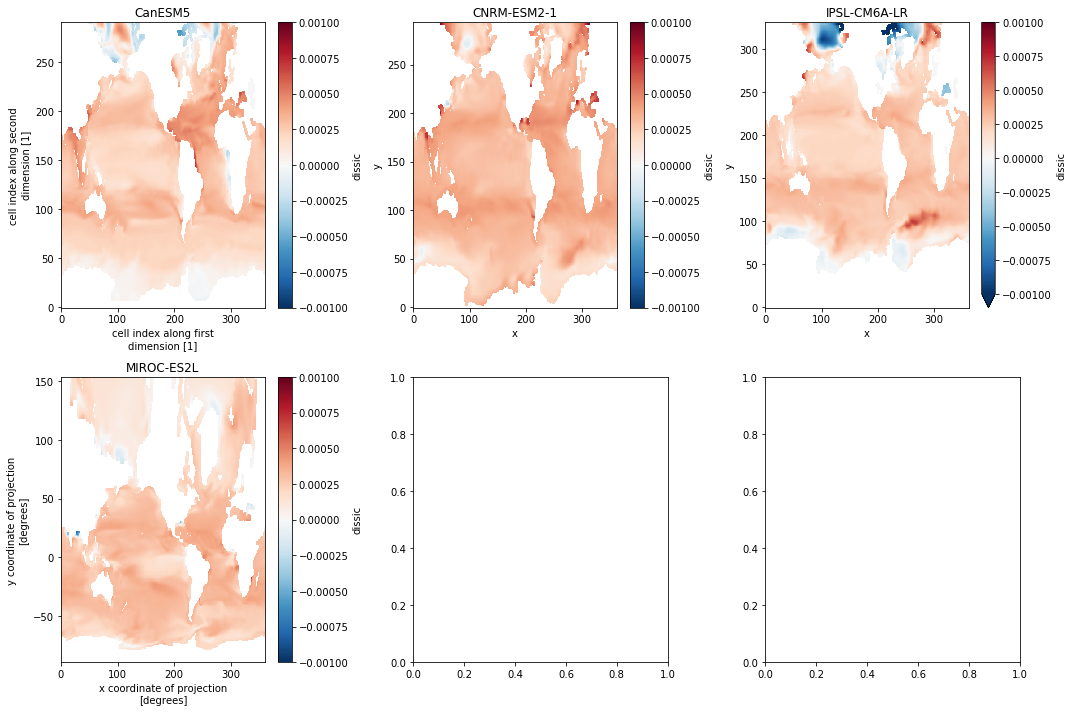

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=2,figsize=[15, 10])
A = 0
for model_key in data_dict_dic.keys():
    dsC = data_dict_dic[model_key]
    ds = dsC['dissic'].isel(lev = 0).chunk({'time': -1, 'x': 110, 'y': 110, 'member_id': 10})
    #dz = dsC['thkcello'].isel(member_id=0)
    #DICstore_slope = (ds.isel(time=-np.arange(10*12)).mean('time')*dz-ds.isel(time=np.arange(10*12)).mean('time')*dz).sum('lev')
    slope = compute_slope(ds)
    slope = slope.compute()
    slope = slope.mean('member_id')*12 # in mol/m^3/year
    A1 = int(np.floor(A/3))
    A2 = np.mod(A,3)
    slope.plot(ax = ax[A1][A2],vmax = 0.001)
    ax[A1][A2].title.set_text(model_key)
    A += 1
fig.tight_layout()
fig.savefig('rate_of_change_DIC_surface_historical.png')

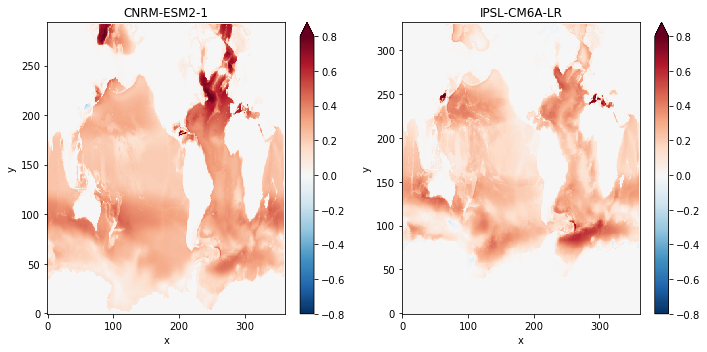

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=[10, 5])
A = 0
for model_key in data_dict_thk.keys():
    dsC = data_dict_thk[model_key]
    ds = dsC['dissic']
    dz = dsC['thkcello'].isel(member_id=0)
    DICstore = (ds*dz).sum('lev').chunk({'time': -1, 'x': 110, 'y': 110, 'member_id': 10})
    slope = compute_slope(DICstore)
    slope = slope.compute()
    slope = slope.mean('member_id')*12 # in mol/m^3/year
    slope.plot(ax = ax[A],vmax = 0.8)
    ax[A].title.set_text(model_key)
    A += 1
fig.tight_layout()
fig.savefig('rate_of_change_DIC_content_historical.png')

# Load heat content

In [16]:
cat = col.search(experiment_id=['historical'], table_id='Omon', variable_id=['thetao','thkcello'], grid_label='gn')

import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [17]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, table_id=['Omon','Ofx'], 
                 variable_id=['thetao','thkcello'], grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# for oxygen, ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# UKESM has an issue with the attributes
models = models - {'HadGEM3-GC31-LL','UKESM1-0-LL'}
#{'UKESM1-0-LL','GISS-E2-1-G-CC','GISS-E2-1-G','MCM-UA-1-0'}

models = list(models)
models

['CESM2',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-G',
 'NESM3',
 'MIROC6',
 'BCC-CSM2-MR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'CanESM5',
 'NorCPM1',
 'GFDL-ESM4',
 'SAM0-UNICON',
 'CAMS-CSM1-0',
 'IPSL-CM6A-LR',
 'FGOALS-f3-L',
 'CNRM-ESM2-1',
 'BCC-ESM1',
 'GFDL-CM4',
 'EC-Earth3-Veg',
 'AWI-CM-1-1-MR',
 'CNRM-CM6-1']

In [18]:
# read all data with thickness and DIC for DIC storage
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict_heat_thk = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['thkcello','thetao'],
                    table_id = ['Omon'],
                    source_id = models,
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['thkcello','thetao']
                    )
#data_dict_heat_thk['IPSL-CM6A-LR'] = data_dict_heat_thk['IPSL-CM6A-LR'].rename({'olevel':'lev'})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 21 group(s)
BCC-CSM2-MR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
BCC-ESM1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-CM6-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


# Plot heat content

In [19]:
data_dict_heat_thk.keys()

dict_keys(['BCC-CSM2-MR', 'BCC-ESM1', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR'])

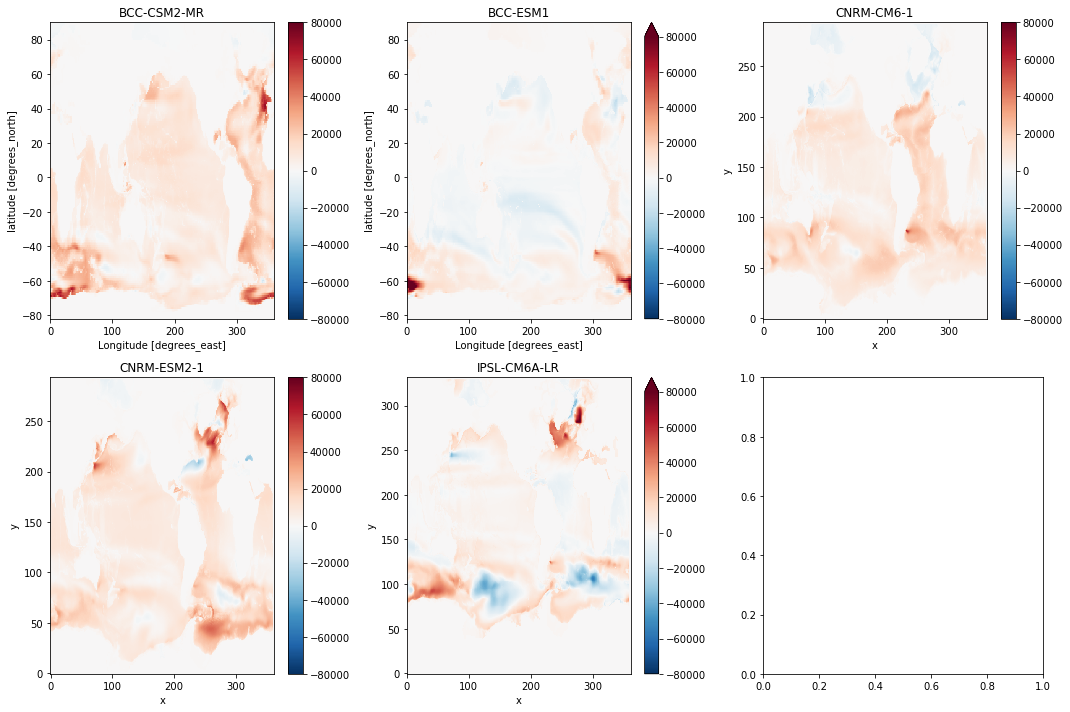

In [20]:
fig, ax = plt.subplots(ncols=3, nrows=2,figsize=[15, 10])
A = 0
for model_key in data_dict_heat_thk.keys():
    dsC = data_dict_heat_thk[model_key]
    ds = (dsC['thetao']+273.15)*4.15*1e6/1025 # heat content (assume constant density and heat capacity)
    dz = dsC['thkcello'].isel(member_id=0)
    DICstore = (ds*dz).sum('lev').chunk({'time': -1, 'x': 110, 'y': 110, 'member_id': 10})
    slope = compute_slope(DICstore)
    slope = slope.compute()
    slope = slope.mean('member_id')*12 # in mol/m^3/year
    A1 = int(np.floor(A/3))
    A2 = np.mod(A,3)
    slope.plot(ax = ax[A1][A2],vmax = 80000)
    ax[A1][A2].title.set_text(model_key)
    A += 1
fig.tight_layout()
fig.savefig('rate_of_change_heat_content_historical.png')

# Load oxygen content

In [21]:
cat = col.search(experiment_id=['piControl'], table_id='Omon', variable_id=['o2','thkcello'], grid_label='gn')

import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [22]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, table_id=['Omon','Ofx'], 
                 variable_id=['o2','thkcello'], grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# for oxygen, ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# UKESM has an issue with the attributes
models = models - {'UKESM1-0-LL'}
#{'UKESM1-0-LL','GISS-E2-1-G-CC','GISS-E2-1-G','MCM-UA-1-0'}

models = list(models)
models

['IPSL-CM6A-LR',
 'HadGEM3-GC31-LL',
 'BCC-CSM2-MR',
 'CNRM-ESM2-1',
 'BCC-ESM1',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'CanESM5',
 'SAM0-UNICON',
 'CNRM-CM6-1']

In [ ]:
# read all data with thickness and o2 for o2 content
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict_o2_thk = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['thkcello','o2'],
                    table_id = ['Omon'],
                    source_id = models,
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['thkcello','o2']
                    )
#data_dict_o2_thk['IPSL-CM6A-LR'] = data_dict_o2_thk['IPSL-CM6A-LR'].rename({'olevel':'lev'})

# Plot O2 content

In [ ]:
data_dict_o2_thk.keys()

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=[10, 5])
A = 0
for model_key in data_dict_o2_thk.keys():
    dsC = data_dict_o2_thk[model_key]
    ds = dsC['o2']
    dz = dsC['thkcello'].isel(member_id=0)
    DICstore = (ds*dz).sum('lev').chunk({'time': -1, 'x': 110, 'y': 110, 'member_id': 10})
    slope = compute_slope(DICstore)
    slope = slope.compute()
    slope = slope.mean('member_id')*12 # in mol/m^3/year
    slope.plot(ax = ax[A],vmax = 0.8)
    ax[A].title.set_text(model_key)
    A += 1
fig.tight_layout()
fig.savefig('rate_of_change_o2_content_historical.png')